We have decided to publish the project results at the beginning with the aim of give to the reader tools to follow its development knowing where we are going.

### Results :

In this assignment we have the task to predict sotck prices given the daily volume and the daily open prices.

We have faced some difficulties in adjusting some of the models and in testing their robustness aginst the day period that is being used to evaluate the predictions.

First we test with the hardest model to train, the LSTM model. This model had a difficulty associated with the demand of computational resources, we tested it for 2 epochs and 30 epochs of training and its predictions does not show to be that good. This was done using the whole dataset, which is the fastest case that we could test. The cases for sector (group of stocks by GICS sector) and stock (by symbol column) segmentation of the training data were not built because of these difficulties.

Then we proceed to adjust XGBoost and Linear Regression to each of the cases demanded:

1. Whole data training.
2. Data divided by sector.
3. Data divided by stock.

We then calculate the MAE and the RMSE for the 6 cases, predicting a random particular day: 2014-12-23

With this in mind we have identified that the performance of the models is in the next order going from the best one to the worst one:

1. Linear Regression - Whole dataset
2. Linear Regression - Data segmented by sector
3. Linear Regression - Data segmented by stock
4. XGBoost - Data segmented by stock
5. XGBoost - Data segmented by sector
6. XGBoost - Whole dataset
7. LSTM - Whole dataset

This would suggest that the best model for building a financial strategy would be the linear regression adjusted over the whole data, but when we start defining how our financial strategy will look like we realize that the smaller RMSE not necessarily was the best one predicting the signed tendence of a stock price in a given individual date (optimization parameter). Because of this we decide to test the robustness of the best models (the linear ones) against the perturtabion of the date or date range that is being predicted.

After we perform this disturbances we capture the net profit associated with the financial strategy suggested by the linear models in each scenary tested (1 day predicted, last 7 days predicted, 30 random days predicted).

In accordance to this test we end with the next conclusion about the best profit models:

1. Linear Regression - Data segmented by stock
2. Linear Regression - Data segmented by sector
3. Linear Regression - Whole data

This is kind of counterintuitive because the RMSE tendency gets inverted when considering the net profit. But since for our strategy we just care about the sign of the change of the prices inside the same day and not the exact quantity of the error associated to each prediction we can see that this changes are best predicted by models adjusted over the individual stock segmented data.

Supporting this idea is the fact that we have positive net profits for each of the perturbation scenariums over the stock segmented model. While in the other cases we have negative profits in some of the treatments.

This lead us to suggest that maybe a good approach would be to change the original problem from a regression one to a classification one, and that's why we decided finally to generate a binary column named change, which represents the algebraic sign of the change. Defining this new variable as follows:

$$1~if~change>0$$
$$0~if~change<0$$

We choose pycaret to test which classification algorithm suits best for the data using its automatic implementation to try this. At the end we were not able to test every possible model but form the ones that we could adjust we can see that the top five according to the accuracy of the model would be:

1. Ridge calssifier
2. Quadratic Discriminant Analys
3. ADA-Boost
4. Logistic Regression
5. Naive Bayes
6. KNN-Classifier

All the accuracies of this models are around the 0.5 value.

Finally we test our linear model adjusted over the segmented data by stock changing the 22 day interval originally used to the values 5, 10, 20 and 30. We can gladly see that the accuracies estimated for this models are around the values obtained inside the classification paradigm, reaching the maximim value at 10 days. Additionally we have that for the values of 5, 10, 22 and 30 we have positive profits, and for the day 20 the profit is negative but comparativelly low if checked against the positive ones. 

More tests are necessary but the intuition suggest that maybe the increase in the time interval used for predicting could improve the model performance in terms of accuracy as in terms of profit.

### Etape 1 :

Construire un modèle de prédiction du stock au closing (XGBOOST, LSTM, Linear Regression).

In [42]:
# Loading modules

import numpy as np
import pandas as pd
import os
import warnings; warnings.simplefilter('ignore')
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn import set_config
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import random
from math import floor

Loading the datasets found on kaggle site:

In [43]:
# Loading data
df_price = pd.read_csv('datasets/prices.csv')
df_fundamentals=pd.read_csv('datasets/fundamentals.csv')
df_price_split_adjusted = pd.read_csv('datasets/prices-split-adjusted.csv')
df_securities = pd.read_csv('datasets/securities.csv')

In [44]:
# Cleaning date column
df_price['date_transform'] = df_price['date'].str[:10]
df_price['date_transform'] = [dt.datetime.strptime(date, '%Y-%m-%d') for date in df_price['date'].str[:10]]

Trying to replicate the LSTM model found on kaggle but applied to our case. For that we define a function to implement the method over the data.

In [54]:
def LSTM_model(df1) :

    X=df1[['open']]
    y=df1['close']
    dates = df1['date_transform']
    length=2
    
    border = floor(len(X)*.7)
    training_set = X.iloc[:border].values
    test_set = X.iloc[border:].values
    test_dates = dates[border:]
    
    maxOpen = max(df1['open'])
    minOpen = min(df1['open'])

    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(training_set)
    test_set_scaled=sc.transform(test_set)

    X_train = []
    y_train = []

    for i in range(length, len(training_set)):
        X_train.append(training_set_scaled[i-length:i, 0])
        y_train.append(training_set_scaled[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    X_test = []
    y_test = []
    for i in range(length, len(test_set)):
        X_test.append(test_set_scaled[i-length:i, 0])
        y_test.append(test_set_scaled[i, 0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    model = Sequential()
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs = 1)
    pred=model.predict(X_test)

    y_test = y_test.reshape(-1, 1)
    sc = MinMaxScaler(feature_range = (minOpen, maxOpen))
    pred_scaled = sc.fit_transform(pred)
    y_test_scaled = sc.transform(y_test)

    test=pd.DataFrame(columns = ['test','pred'])
    test['test'] = y_test_scaled.flatten()
    test['pred'] = pred_scaled.flatten()

    return test

Running model for 30 epochs:

In [83]:
pred = LSTM_model(df_price)

Epoch 1/30
18622/18622 [==============================] - 177s 9ms/step - loss: 0.0030 - val_loss: 0.0054
Epoch 2/30
18622/18622 [==============================] - 167s 9ms/step - loss: 0.0028 - val_loss: 0.0057
Epoch 3/30
18622/18622 [==============================] - 162s 9ms/step - loss: 0.0028 - val_loss: 0.0055
Epoch 4/30
18622/18622 [==============================] - 159s 9ms/step - loss: 0.0027 - val_loss: 0.0052
Epoch 5/30
18622/18622 [==============================] - 141s 8ms/step - loss: 0.0027 - val_loss: 0.0054
Epoch 6/30
18622/18622 [==============================] - 127s 7ms/step - loss: 0.0027 - val_loss: 0.0053
Epoch 7/30
18622/18622 [==============================] - 128s 7ms/step - loss: 0.0027 - val_loss: 0.0053
Epoch 8/30
18622/18622 [==============================] - 128s 7ms/step - loss: 0.0027 - val_loss: 0.0052
Epoch 9/30
18622/18622 [==============================] - 128s 7ms/step - loss: 0.0027 - val_loss: 0.0053
Epoch 10/30
18622/18622 [=====================

In [84]:
print(pred)

              test        pred
0        25.042374   95.536301
1       120.441172   83.003975
2        18.929247   76.673676
3        40.440250   87.362869
4        40.730399   74.696396
...            ...         ...
255373  102.552018   86.684906
255374   42.281192   96.942764
255375   52.856600   86.847977
255376   43.942041   92.879074
255377   53.416889  100.361801

[255378 rows x 2 columns]


Running LSTM model just for 30 epochs the training took a lot of time. But the results were not that encouraging. Since the net profit calculated for the predictions turns out to be negative. We think that this bad results can be related to the fact that the algorithm get stocked in a local minimum. Maybe with more computational resources we could test more this paradigm, but since the results are worst that any of the models trained below we are going to follow the project studying those who did achieve reasonable results. 

Here we can constate that we are not achieving good predictions for our test data, also this model demands a lot of computational resources. We have test its training with just 2 epochs and the predictions don't seem to get better if we do them with 30 epochs. Then since we would like to adjust this model over the whole dataset, but also over the data segmented bye stock sector and by stock we don't have enough temporal and physique resources to achieve this protocol. And since this is important to evaluate the robustness of our model in accordance to the profits achieved we are going to perform this adjustments just with the other two modelling alternatives: Linear regression and Xgboost to find which of these ones gives us the best profit.

For that we take as basis the function that professor has provided in the code assignment. We have modified this function for allowing the adjustment of both models over different segmentatios of the data.

Also an important modification is that when we segment the data we end with less dates than if we consider the whole dataset, this could lead to errors if we want to predict a particular asset with the 22 days before the date that we are trying to predict, that's why we not take this 22 days forcely but we try to fin the nearest 22 days given the prediction date to achieve a succesful training for the model.

Finally before adjusting the Linear Regrassion and the XGBoost we have to remember that we are dealing with temporally correlated data. And eventhough that we are not directly dealing with this by choosin a temporal series analysis, the chose of 22 days is kind of taking into account this factor. At the end when we have our winner model we are going to test it for the best profit model testing several day predicting intervals (10, 20, 30), to see how this definition affects the results.

In [4]:
# Fonction qui permet d'effectuer une prédiction basée sur une régression linéaire 
# pour une date donnée 
def linear_regression(df, date, nbjourtraining: int, method = 'linear_reg'):
    #df: dataframe en entrée pour la création de l'analyse
    #date: date pour laquelle on veut effectuer la prédiction
    #nbjourtraining: le nombre de jour qu'on veut utiliser pour l'apprentissage
    
    #Création du X et du Y
    X=df[['date_transform', 'symbol','volume','open']]
    y=df[['date_transform', 'symbol','close']]
    
    #définition de la date min de l'entrainement
    #print(df['date_transform'].min())
    #print(df['date_transform'].max())
    date_min = list(df[df['date_transform']<date]['date_transform'].unique())[-nbjourtraining:][0]

    #Création du X de test et de train
    XX_train = X[(X['date_transform'] < date) & (X['date_transform'] > date_min)]
    XX_test = X[X['date_transform'] == date]
    #print(XX_test.head)
    dia = 0
    date0 = dt.datetime.strptime(date, '%Y-%m-%d')
    date_mod = str(date0 + timedelta(days=dia))[:10]
    #print(date_mod)
    #print(len(XX_test['symbol'].unique()))
    while len(XX_test) == 0 :
        dia = dia + 1
        date_mod = str(date0 + timedelta(days=dia))[:10]
        XX_test = X[X['date_transform'] == date_mod]
        #print(len(XX_test['symbol'].unique()))# Have to correct the min date
        
    #Création du y de test et de train
    yy_train = y[(y['date_transform'] < date) & (y['date_transform'] > date_min)]
    yy_test = y[y['date_transform'] == date_mod]
    #print(len(yy_test))
    # Sélection des champs numériques qui vont servir d'input
    X_train = XX_train[['volume','open']]
    #print(X_train)
    X_test = XX_test[['volume', 'open']]
    y_train = yy_train['close']
    y_test = yy_test['close']
    
    # Transformation en loi normale centré réduite des données d'entrées
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Création du modèle de régréssion linéaire
    if method == 'linear_reg':
        model = LinearRegression()
        model.fit(X_train,y_train)
        set_config(display = 'diagram')
        pred = model.predict(X_test)
    
    # Création du modéle de XGboost
    if method == 'xgboost' :
        #print("voy")
        model = XGBRegressor()
        model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
        #cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
        # evaluate model
        #scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        
    # Création de la restitution
    pred_df = pd.DataFrame(pred,yy_test.index,['prediction'])
    df_restit = yy_test.merge(pred_df, left_index=True, right_index=True, how="inner")
    df_restit = XX_test.merge(df_restit[['close','prediction']], left_index=True, right_index=True, how="inner")
    
    return df_restit

### Handmade functions

According to the indications, we have the following hand made functions that are requested in the problem statement.

We present one for calculating MAE, RMSE and another one that does the calculation over the predicted output.

Then we build another function that is the one for setting the financial strategy.

In [5]:
def MAE (df_restit) :
    return(sum(abs(df_restit['prediction']-df_restit['close']))/len(df_restit['close']))

def RMSE (df_restit) :
    return((sum(((df_restit['prediction']-df_restit['close'])**2))/len(df_restit['close']))**(1/2))

def calculate_MAE_MSE(df_restit, pred = None) :

    if pred is None : 
        mae = MAE(df_restit)
        rmse = RMSE(df_restit)
        dictionary = {'MAE' : [mae], 'RMSE' : [rmse]}
    if pred == 'stock':
        mae = MAE(df_restit)
        rmse = RMSE(df_restit)
        dictionary = {'STOCK' : df_restit['symbol'], 'MAE' : [mae], 'RMSE' : [rmse]}
    if pred == 'sector':
        stocks = df_restit['symbol'].unique()
        lista_MAE = [MAE(df_restit[df_restit['symbol'] == stock]) for stock in stocks]
        lista_RMSE = [RMSE(df_restit[df_restit['symbol'] == stock]) for stock in stocks]
        dictionary = {'STOCK' : stocks, 'MAE' : lista_MAE, 'RMSE' : lista_RMSE}
    if pred == 'total' :
        stocks = df_restit['symbol'].unique()
        lista_MAE = [MAE(df_restit[df_restit['symbol'] == stock]) for stock in stocks]
        lista_RMSE = [RMSE(df_restit[df_restit['symbol'] == stock]) for stock in stocks]
        dictionary = {'STOCK' : stocks, 'MAE' : lista_MAE, 'RMSE' : lista_RMSE}
        
    output = pd.DataFrame(dictionary)
    return output

def build_strategy_profit_calc (predicciones) :
    
    cambio_pred = (predicciones['prediction']-predicciones['open'])*predicciones['volume']
    cambio_real = (predicciones['close']-predicciones['open'])*predicciones['volume']
    estrategia_pred = ["Buy" if cambio > 0 else ("Sell" if cambio < 0 else random.sample(('Sell','Buy'),1)[0]) for cambio in cambio_pred]#if cambio < 0 else "Hold" if cambio == 0 ]
    realidad = ["Buy" if cambio > 0 else ("Sell" if cambio < 0 else random.sample(('Sell','Buy'),1)[0]) for cambio in cambio_real]
    predicciones['estrategia_pred'] = estrategia_pred
    predicciones['realidad'] = realidad
    profit = []
    for i in range(0,len(estrategia_pred)) :
        if estrategia_pred[i] == realidad[i] :
            if estrategia_pred[i] == 'Buy' :
                profit = np.append(profit, cambio_real.iloc[i])
            if estrategia_pred[i] == 'Sell' :
                profit = np.append(profit, abs(cambio_real.iloc[i]))
        if estrategia_pred[i] != realidad[i] :
            if estrategia_pred[i] == 'Buy' :
                profit = np.append(profit, cambio_real.iloc[i])
            if estrategia_pred[i] == 'Sell' :
                profit = np.append(profit, -1*cambio_real.iloc[i])
    predicciones['profit'] = profit
    
    return predicciones
    

def catch(func, handle=lambda e : e, *args, **kwargs) :
    try:
        return func(*args, **kwargs)
    except Exception as e:
        return print(e)

In [6]:
# Exemple de l'usage de la fonction
predicciones_totales = linear_regression(df_price, '2014-12-23', 22)
#df_output_one_day
errors = calculate_MAE_MSE(predicciones_totales,'total')
errors.describe()

,MAE,RMSE
count,490.000000,490.000000
mean,0.780217,0.780217
std,1.571113,1.571113
min,0.000397,0.000397
25%,0.148669,0.148669
50%,0.339085,0.339085
75%,0.770027,0.770027
max,17.745193,17.745193


### Business strategy definition:

We have a typical temporal data of stock market prices, then we have the following columns:

1. open : Open unitary price of a particular stock
2. close :  Close unitary price of a particular stock
3. volume : Volume that can be sold or buied 
4. date : Date

We are going to define the following financial strategy:

Giving the closing unitary price as dependent variable we can predict using several models. Then having this prediction we can compare it with the corresponding opening price by stock given in the test data.

**If the prediction is greater than the opening price we are going to BUY the volume reported in volume column but if the prediction is lower then we are going to SELL it.**

This strategy is in accordance with the assumption that one would like to SELL knowing that the price at the opening will remain bigger than the closing-predicted one, in order to have the biggest earning. Complementary to this would be the BUY strategy that would be taken if the prediction-closing is greater than the opening price, because we would be buying cheaper.

Then we would have four possibilites for our predicted strategies (REAL SCENARIO STRATEGY, PREDICTED STRATEGY):

INCORRECT: (SELL, BUY) (BUY, SELL)

CORRECT: (SELL, SELL) (BUY, BUY)

In [7]:
db_estrategia = build_strategy_profit_calc(predicciones_totales)
#
tab = db_estrategia.groupby(['estrategia_pred', 'realidad']).size()
tipos = db_estrategia['estrategia_pred'] + db_estrategia['realidad']
db_estrategia['type'] = ['correct' if (tipo == 'BuyBuy' or tipo == 'SellSell') else 'incorrect' for tipo in tipos]
incorrect = db_estrategia[db_estrategia['type'] == 'incorrect']
correct = db_estrategia[db_estrategia['type'] == 'correct']
#
errors_incorrect = calculate_MAE_MSE(incorrect,'total')
errors_correct = calculate_MAE_MSE(correct,'total')
print("Incorrect strategy")
print(errors_incorrect.describe())
print(sum(incorrect['profit']))
print("Correct strategy")
print(errors_correct.describe())
print(sum(correct['profit']))
print("Net profit:")
profit_lm_1day = sum(db_estrategia['profit'])
print(profit_lm_1day)

Incorrect strategy
              MAE        RMSE
count  216.000000  216.000000
mean     0.718301    0.718301
std      0.905087    0.905087
min      0.032840    0.032840
25%      0.166359    0.166359
50%      0.331093    0.331093
75%      0.894597    0.894597
max      5.804755    5.804755
-457044080.7502006
Correct strategy
              MAE        RMSE
count  274.000000  274.000000
mean     0.829026    0.829026
std      1.941867    1.941867
min      0.000397    0.000397
25%      0.106680    0.106680
50%      0.339827    0.339827
75%      0.703146    0.703146
max     17.745193   17.745193
997981341.5307001
Net profit:
540937260.7804999


This profit is positive taking into account both types of strategies the correct and incorrect ones. Now since this model is the one with the smallest RMSE we are going to test its quality predicting 30 random dates into he interval of interest and finally a week (7 days) of the last dates of the interval.

In [8]:
### Generating random vector of dates
mindate = df_price['date_transform'].describe()[4]
maxdate = df_price['date_transform'].describe()[5]

last_week = pd.date_range(start = (maxdate-timedelta(days=7)).strftime(format = "%Y-%m-%d"), end = maxdate).tolist()
last_week = [date.strftime(format = "%Y-%m-%d") for date in last_week]

dates = pd.date_range(start = mindate.strftime(format = "%Y-%m-%d"), end = maxdate.strftime(format = "%Y-%m-%d")).tolist()
dates = [date.strftime(format = "%Y-%m-%d") for date in dates]

random.seed(3141)
N = 30
list_N_dates = random.sample(dates, N)

In [9]:
lista_predicciones_N_dates = [linear_regression(df_price, date, 22) for date in list_N_dates]

In [10]:
lista_predicciones_last_week = [linear_regression(df_price, date, 22) for date in last_week]

Net profit for random 30 days
-4485181884.194616
Net profit for last 7 days
-689140909.0945998


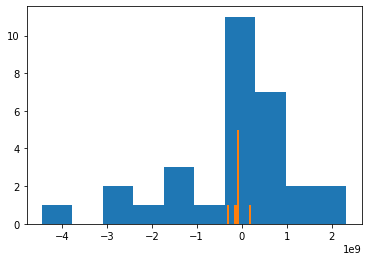

When we calculate the net profit obtained for the last 7 days of the date range in accordance with his model we end with a net negative profit. Then eventhough that for the random 30 days this profit is bigger it continues to be negative, meaning we are loosing money. This is important because in comparisson with the following models this has the smallest RMSE. Next we will check if the profits are in accordance with the logic of being bigger if the RMSE is smaller.

### Segmentating models by stock:

In [9]:
conteos_stock = df_price['symbol'].value_counts()
stocks = conteos_stock.index
conteos_stock
# Dividing the dataset by stock
lista_db_stock = [df_price[df_price['symbol'] == stock] for stock in stocks]

In [52]:
lista_pred_stock = [catch(lambda: linear_regression(db_stock, '2014-12-23', 22)) for db_stock in lista_db_stock ]
db_error_stock = pd.concat([catch(lambda: calculate_MAE_MSE(predicciones)) for predicciones in lista_pred_stock])
db_error_sotck = db_error_stock.sort_values(['MAE'], ascending=True)
db_error_stock.describe()

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable


,MAE,RMSE
count,490.000000,490.000000
mean,0.855063,0.855063
std,1.491111,1.491111
min,0.004138,0.004138
25%,0.189714,0.189714
50%,0.435424,0.435424
75%,0.910630,0.910630
max,19.777266,19.777266


In [60]:
one_day_stock = build_strategy_profit_calc(pd.concat(lista_pred_stock))
profit_lm_stock_1day = sum(one_day_stock['profit'])
print(sum(one_day_stock['profit']))

206933641.93110028


We have that in average the predictions of this segmentation model is greater than the previous one. Here we are building the predictions with datasets that are segmentated according to the corresponding asset that is taken into account.

Now we are going to check how does the profit changes by predicting over the same 30 random days, and over the last 7 days of the dataset.

In [38]:
lm_stock_profit0 = []
for i in range(0,len(list_N_dates)):
    print(i)
    pred_stock = pd.concat([catch(lambda: linear_regression(db_stock, list_N_dates[i], 22)) for db_stock in lista_db_stock])
    db_strategy_stock = build_strategy_profit_calc(pred_stock)
    lm_stock_profit0.append(sum(db_strategy_stock['profit']))
print(lm_stock_profit0)

0
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
1
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
2
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index

18
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
19
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index

In [75]:
profit_lm_stock_lastw = lm_stock_profit[8:]
profit_lm_stock_lastw = sum(profit_lm_stock_lastw)

In [32]:
lm_stock_profit = []
for i in range(0,len(last_week)):
    print(i)
    pred_stock = pd.concat([catch(lambda: linear_regression(db_stock, last_week[i], 22)) for db_stock in lista_db_stock])
    db_strategy_stock = build_strategy_profit_calc(pred_stock)
    lm_stock_profit.append(sum(db_strategy_stock['profit']))
print(lm_stock_profit)

0
1
2
3
4
5
6
7
[44824297.35899967, 148716386.55560037, 148716386.55560037, 148716386.55560037, 148716386.55560037, -471879224.61400044, -302817522.2063005, 297417137.5544995]


In [62]:
profit_lm_stock_Ndays = sum(lm_stock_profit)
print(profit_lm_stock_Ndays)

10494056983.267673


Notice that the profit in this case is positve for the last 7 days and also for the random 30 days. This is encouraging, because even that the RMSE is less in the model that accounts for all the date in its training its is profit is negative. 

Then we can suggest that predicting the tendence of the stock prices gets a better profit when segmentating the date even that we have less precission. 

### Segmentating models by similar stocks grouped by GICS sector

In [10]:
sector_stock = df_securities[['Ticker symbol','GICS Sector']]
sectors = sector_stock['GICS Sector'].unique()

df_price_sector = pd.merge(left = df_price, 
                           right = sector_stock, 
                           how = 'inner', 
                           left_on = 'symbol', 
                           right_on = 'Ticker symbol')

print(len(df_price))
print(len(df_price_sector))
# Dividing the dataset by stock
lista_db_sector = [df_price_sector[df_price_sector['GICS Sector'] == sector] for sector in sectors]
sectors

851264
851264


array(['Industrials', 'Health Care', 'Information Technology',
       'Consumer Discretionary', 'Utilities', 'Financials', 'Materials',
       'Consumer Staples', 'Real Estate', 'Energy',
       'Telecommunications Services'], dtype=object)

In [44]:
lista_pred_sector = [catch(lambda: linear_regression(db_sector, '2014-12-23', 22)) for db_sector in lista_db_sector]
db_error_sector = pd.concat([catch(lambda: calculate_MAE_MSE(predicciones, 'sector')) for predicciones in lista_pred_sector])
db_error_sector.describe()

,MAE,RMSE
count,490.000000,490.000000
mean,0.820743,0.820743
std,1.646277,1.646277
min,0.002053,0.002053
25%,0.166544,0.166544
50%,0.356462,0.356462
75%,0.811186,0.811186
max,18.513224,18.513224


Here we can see that in a one day prediction the Error is in average less than the one for the sotck models. And if we check this one day profit we have:

In [64]:
one_day_sector = build_strategy_profit_calc(pd.concat(lista_pred_sector))
profit_lm_sector_1day = sum(one_day_sector['profit'])
print(profit_lm_sector_1day)

-194892893.12810025


Adjusting the model by the same 30 random dates and the last 7 days we can compare which model gives a better profit and with this we can account for its robustnees in accordance to the financial strategy chosen.

In [46]:
# Predicting 30 random days
lm_sector_profit0 = []
for i in range(0,len(list_N_dates)):
    print(i)
    pred_sector = pd.concat([catch(lambda: linear_regression(db_sector, list_N_dates[i], 22)) for db_sector in lista_db_sector])
    db_strategy_sector = build_strategy_profit_calc(pred_sector)
    lm_sector_profit0.append(sum(db_strategy_sector['profit']))
print(lm_sector_profit0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
[246551913.93030176, 196434214.9522998, -1242363268.241898, 528907709.20710015, 796880786.2052021, -4670559380.842802, -1238215730.8104067, 682719347.1598006, -905551180.5180091, 328098592.57180035, 2057777009.308888, 527946987.4277995, 835952742.3977964, -2489104264.781805, 1063542645.4810069, 112600991.90269992, -1161962308.0158017, -193442576.7124008, 719841748.1043037, 111881106.32760058, 182192829.64140028, 45489389.65000338, 386006871.4628982, -1960208124.0796053, -1155262067.6264029, -215995782.49039766, 967208060.3543996, 701215534.3059001, -155482482.6445976, 666710047.1991]


In [68]:
profit_lm_sector_Ndays = sum(lm_sector_profit0)
print(profit_lm_sector_Ndays)

-4230188639.173825


In [49]:
# Predicting last 7 days
lm_sector_profit = []
for i in range(0,len(last_week)):
    print(i)
    pred_sector = pd.concat([catch(lambda: linear_regression(db_sector, last_week[i], 22)) for db_sector in lista_db_sector])
    db_strategy_sector = build_strategy_profit_calc(pred_sector)
    lm_sector_profit.append(sum(db_strategy_sector['profit']))
print(lm_sector_profit)

0
1
2
3
4
5
6
7
[-77874124.91900036, -178408649.9337999, -178408649.9337999, -178408649.9337999, -178408649.9337999, -680817380.7842015, -354523868.5669005, 593394509.4799006]


In [67]:
profit_lm_sector_lastw = sum(lm_sector_profit)
print(profit_lm_sector_lastw)

-1233455464.525401


In [55]:
db_error_stock = pd.concat([catch(lambda: calculate_MAE_MSE(predicciones, 'stock')) for predicciones in lista_pred_stock])
db_error_sector = pd.concat([catch(lambda: calculate_MAE_MSE(predicciones, 'sector')) for predicciones in lista_pred_sector])
db_error_total = catch(lambda: calculate_MAE_MSE(predicciones_totales, 'total'))
db_error = pd.merge(left = pd.merge(left = db_error_total, 
                                     right = db_error_sector,
                                     how = 'outer',
                                     on = 'STOCK'
                                    ),
                     right = db_error_stock,
                     how = 'inner',
                     on = 'STOCK'
                    )

db_error.describe()

'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable


,MAE_x,RMSE_x,MAE_y,RMSE_y,MAE,RMSE
count,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000
mean,0.780217,0.780217,0.820743,0.820743,0.855063,0.855063
std,1.571113,1.571113,1.646277,1.646277,1.491111,1.491111
min,0.000397,0.000397,0.002053,0.002053,0.004138,0.004138
25%,0.148669,0.148669,0.166544,0.166544,0.189714,0.189714
50%,0.339085,0.339085,0.356462,0.356462,0.435424,0.435424
75%,0.770027,0.770027,0.811186,0.811186,0.910630,0.910630
max,17.745193,17.745193,18.513224,18.513224,19.777266,19.777266


If we take into account the RMSE and the MAE the best model is the one which has been adjusted over the whole dataset and the worst one is the one adjusted by each stock data segment (i.e. 501 models were adjusted).

But if we consider that what we want to predict according to our financial strategy is the tendency of the stock prices into one day and that we don't care that much about the exact quantity. Maybe the RMSE is not the best metric for optimizin this strategy. Comparing the profits calculated for 1, 7 and 30 days predictions the best model would the one with the higgest RMSE. This can be seen in the next table.

### Linear models predictions compared between 1, 7 and 30 days.

In [78]:
list_lm_one_day = [profit_lm_1day, profit_lm_sector_1day, profit_lm_stock_1day]
list_lm_last7 = [profit_lm_lastw, profit_lm_sector_lastw, profit_lm_stock_lastw]
list_rand_Ndays = [profit_lm_Ndays, profit_lm_sector_Ndays, profit_lm_stock_Ndays]

net_profits_lm = pd.DataFrame({'1_day' : list_lm_one_day, 'last_7_days' : list_lm_last7, 'random_30_days': list_rand_Ndays})
net_profits_lm.index = ['All', 'Sector', 'Stock']  
display(net_profits_lm)

,1_day,last_7_days,random_30_days
All,5.409373e+08,-6.891409e+08,-4.485182e+09
Sector,-1.948929e+08,-1.233455e+09,-4.230189e+09
Stock,2.069336e+08,1.033165e+10,1.049406e+10


### Repeating protocol for XGboost

1. Adjusting model for the total dataset

In [12]:
predicciones_totales_xgb = linear_regression( df_price, '2014-12-23', 22, method = 'xgboost')
db_error_total_xgb = calculate_MAE_MSE(predicciones_totales_xgb,'total')
db_error_total_xgb.describe()

,MAE,RMSE
count,490.000000,490.000000
mean,3.339045,3.339045
std,10.162139,10.162139
min,0.002212,0.002212
25%,0.418025,0.418025
50%,0.819479,0.819479
75%,1.824598,1.824598
max,114.520874,114.520874


In [18]:
profit_xgboost_1day = sum(build_strategy_profit_calc(predicciones_totales_xgb)['profit'])
print(profit_xgboost_1day)

390379517.96769917


2. Adjusting model segmentating db by stock

In [13]:
lista_pred_stock_xgb = [catch(lambda: linear_regression(db_stock, '2014-12-23', 22, 'xgboost')) for db_stock in lista_db_stock ]
db_error_stock_xgb = pd.concat([catch(lambda: calculate_MAE_MSE(predicciones, 'stock')) for predicciones in lista_pred_stock_xgb])
db_error_sotck_xgb = db_error_stock_xgb.sort_values(['MAE'], ascending=True)
db_error_stock_xgb.describe()

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable


,MAE,RMSE
count,490.000000,490.000000
mean,1.515985,1.515985
std,2.262752,2.262752
min,0.000191,0.000191
25%,0.414368,0.414368
50%,0.872162,0.872162
75%,1.768744,1.768744
max,21.091491,21.091491


In [20]:
profit_xgboost_stock_1day = sum(build_strategy_profit_calc(pd.concat(lista_pred_stock_xgb))['profit'])
print(profit_xgboost_stock_1day)

49196918.200699806


3. Adjusting segmentatign db by sector

In [11]:
lista_pred_sector_xgb = [catch(lambda: linear_regression(db_sector, '2014-12-23', 22, 'xgboost')) for db_sector in lista_db_sector]
db_error_sector_xgb = pd.concat([catch(lambda: calculate_MAE_MSE(predicciones, 'sector')) for predicciones in lista_pred_sector_xgb])
db_error_sector_xgb.describe()

,MAE,RMSE
count,490.000000,490.000000
mean,7.550301,7.550301
std,21.765628,21.765628
min,0.013809,0.013809
25%,0.964150,0.964150
50%,2.472813,2.472813
75%,5.677424,5.677424
max,221.996521,221.996521


In [23]:
profit_xgboost_sector_1day = sum(build_strategy_profit_calc(pd.concat(lista_pred_sector_xgb))['profit'])
print(profit_xgboost_sector_1day)

533480871.2798992


In [14]:
db_error_xgb = pd.merge(left = pd.merge(left = db_error_total_xgb, 
                                     right = db_error_sector_xgb,
                                     how = 'outer',
                                     on = 'STOCK'
                                    ),
                     right = db_error_stock_xgb,
                     how = 'inner',
                     on = 'STOCK'
                    )
db_error_xgb.describe()

,MAE_x,RMSE_x,MAE_y,RMSE_y,MAE,RMSE
count,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000
mean,3.339045,3.339045,7.550301,7.550301,1.515985,1.515985
std,10.162139,10.162139,21.765628,21.765628,2.262752,2.262752
min,0.002212,0.002212,0.013809,0.013809,0.000191,0.000191
25%,0.418025,0.418025,0.964150,0.964150,0.414368,0.414368
50%,0.819479,0.819479,2.472813,2.472813,0.872162,0.872162
75%,1.824598,1.824598,5.677424,5.677424,1.768744,1.768744
max,114.520874,114.520874,221.996521,221.996521,21.091491,21.091491


If we consider just one day for predicting by data, stock and sector we have that the three models give us better performances, having all three models positive profits.

Now we are goint to build this predictions for the last 7 days scenarium and for 30 random days considering all the data for training the models

In [24]:
lista_predicciones_xgboost_last_week = [linear_regression(df_price, date, 22, 'xgboost') for date in last_week]

In [25]:
lista_predicciones_xgboost_N_dates = [linear_regression(df_price, date, 22, 'xgboost') for date in list_N_dates]

Net profit for random 30 days
-6882949371.93338
Net profit for last 7 days
-1150239075.1759956


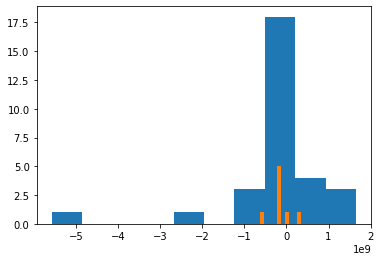

In [28]:
lista_profit_xgboost_N = [sum(build_strategy_profit_calc(prediccion)['profit']) for prediccion in lista_predicciones_xgboost_N_dates]
lista_profit_xgboost_lastw = [sum(build_strategy_profit_calc(prediccion)['profit']) for prediccion in lista_predicciones_xgboost_last_week]
plt.hist(lista_profit_xgboost_N)
plt.hist(lista_profit_xgboost_lastw)
print("Net profit for random " + str(N) + " days")
profit_xgboost_Ndays = sum(lista_profit_xgboost_N)
print(profit_xgboost_Ndays)
print("Net profit for last 7 days")
profit_xgboost_lastw = sum(lista_profit_xgboost_lastw)
print(profit_xgboost_lastw)

Here we can confirm that both net profits the one calculated during the last 7 days predictions and the other calculated for 30 random days are negative. Then eventhough that for one day we got a positive utility, the robustness of the model does not hold when considering more dates.

In [35]:
net_profits_xgboost = pd.DataFrame({'1day':[profit_xgboost_1day , profit_xgboost_sector_1day,  profit_xgboost_stock_1day],
                                    'lastweek':[profit_xgboost_lastw, None, None],
                                    '30_rand_days':[profit_xgboost_Ndays, None, None]})
net_profits_xgboost.index = ['All', 'Sector', 'Stock']  
display(net_profits_xgboost)

,1day,lastweek,30_rand_days
All,3.903795e+08,-1.150239e+09,-6.882949e+09
Sector,5.334809e+08,NaN,NaN
Stock,4.919692e+07,NaN,NaN


### Model improvement

Observing the limitations in accordance to set the problem as a regression one, one can decide to change a little this assumption and consider a classification problem instead.

Next we perform a model comparission using pycaret considering the dependent variable as a binary one. This binary variable definition will considered to be 1 if the open price is less than the close one or 0 otherwise.

In [37]:
difference = df_price['close']-df_price['open']
change = ["Buy" if dif>=0 else "Sell" for dif in difference]
df_price['change'] = change
db = df_price[['volume', 'open', 'change']]
db.head
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   volume  851264 non-null  float64
 1   open    851264 non-null  float64
 2   change  851264 non-null  object 
dtypes: float64(2), object(1)
memory usage: 19.5+ MB


In [38]:
from pycaret.classification import *
clf1 = setup(data = db, target = 'change')
best = compare_models(['lr','nb','qda','ridge','ada','knn']) 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.5227,0.0000,0.0201,0.5109,0.0387,0.0026,0.0092,0.2300
ada,Ada Boost Classifier,0.5227,0.5116,0.0424,0.5040,0.0781,0.0045,0.0108,8.1430
qda,Quadratic Discriminant Analysis,0.5226,0.5050,0.0626,0.5024,0.1113,0.0061,0.0124,0.1700
lr,Logistic Regression,0.5223,0.4918,0.0000,0.0000,0.0000,0.0000,0.0000,2.2910
nb,Naive Bayes,0.5222,0.5028,0.0403,0.4982,0.0745,0.0033,0.0083,0.1430
knn,K Neighbors Classifier,0.5029,0.5015,0.4582,0.4788,0.4682,0.0020,0.0020,2.2630


### Testing the best model by selecting different time intervals for predicting (5, 10, 20, 22, 30)

The best model obtained between all the ones tested was the Linear Regression adjusted over the dataset segmentated by stock. This can be seen checking its profits which all are positive. It should be mentioned that this is the only model that achive this when predicting 1, 7 and 30 days.

In [83]:
intervals = [5, 10, 20, 22, 30]

lista_pred_stock_int = []
lm_stock_profit_interval = []
for i in range(len(intervals)):
    pred_stock = pd.concat([catch(lambda: linear_regression(db_stock, '2014-12-23', intervals[i])) for db_stock in lista_db_stock])
    lista_pred_stock_int.append(pred_stock)
    db_strategy_stock = build_strategy_profit_calc(pred_stock)
    lm_stock_profit_interval.append(sum(db_strategy_stock['profit']))

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

In [84]:
#db_stock_int = pd.concat(lista_pred_stock_int)
accuracy = []
for i in range(len(lista_pred_stock_int)):
    db_stock_int = lista_pred_stock_int[i]
    tab = pd.crosstab(db_stock_int['estrategia_pred'],
                                db_stock_int['realidad']) 
    accuracy.append((tab.iloc[0,0] + tab.iloc[1,1]) / tab.to_numpy().sum())

In [85]:
lm_stock_profit_interval
df_stock_profit_interval = pd.DataFrame({'Predicting inteval' : intervals, 'Estimated profit' : lm_stock_profit_interval, 'Accuracy':accuracy})
display(df_stock_profit_interval)

,Predicting inteval,Estimated profit,Accuracy
0,5,6.780090e+07,0.467347
1,10,1.741597e+08,0.522449
2,20,-5.034771e+06,0.500000
3,22,2.069336e+08,0.504082
4,30,5.779091e+08,0.516327


After evalutaing the best profit model, we can constatate that its accuracy is not that different than the one estimated for the classification alternatives explored with pycaret. But when we examine the profits we can gladly see a majority of positive results, then even that the accuracy es near 0.5, when we take the money factor the model remains as a good utility generator.